In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
a, b, c = -2.0, -2.0, -4.0
lx, ly = np.pi / 2.0, np.pi / 2.0
f = lambda x, t: 0.0
alpha1, beta1, phi1 = 0.0, 1.0, lambda y: np.exp(-y)*np.cos(y)
alpha2, beta2, phi2 = 0.0, 1.0, lambda y: 0.0
alpha3, beta3, phi3 = 0.0, 1.0, lambda x: np.exp(-x)*np.cos(x)
alpha4, beta4, phi4 = 0.0, 1.0, lambda x: 0.0
nx, ny = 35, 35
solution = lambda x, y: np.exp(-x-y)*np.cos(x)*np.cos(y)

In [61]:
class Solver():

    def __init__(self, a, b, c, lx, ly, f, \
                 alpha1, beta1, phi1, \
                 alpha2, beta2, phi2, \
                 alpha3, beta3, phi3, \
                 alpha4, beta4, phi4, \
                 nx, ny):
        self.a, self.b, self.c = a, b, c

        self.lx, self.ly = lx, ly

        self.f = f

        self.alpha1, self.beta1, self.phi1 = alpha1, beta1, phi1
        self.alpha2, self.beta2, self.phi2 = alpha2, beta2, phi2
        self.alpha3, self.beta3, self.phi3 = alpha3, beta3, phi3
        self.alpha4, self.beta4, self.phi4 = alpha4, beta4, phi4

        self.nx, self.ny = nx, ny

        self.hx = lx / nx
        self.hy = ly / ny

        self.result = np.ndarray(shape=((ny+1), (nx+1)), dtype = np.float32)

    def k_ij(self, i, j):
        if (j == 0): return i - 1
        if (j == self.ny): return self.ny * (self.nx + 1) + i - 3

        return j * (self.nx + 1) + i - 2

    def x_i(self, i):
        return self.hx * i

    def y_j(self, j):
        return self.hy * j

    def ji_k(self, k):
        if k < self.nx - 1: return 0, k + 1
        if k >= self.ny * (self.nx + 1) - 2: return self.ny, k - self.ny * (self.nx + 1) + 3

        return (k + 2) // (self.nx + 1), (k + 2) % (self.nx + 1)

    def liebmann(self, epsilon = 0.01):
        k = 0
        while True:
            max_eps = -0.1
            for i in range(1, self.nx):
                for j in range(1, self.ny):
                    self.next[j][i] = (self.alpha_minus * self.result[j][i+1] + \
                                      self.alpha_plus * self.result[j][i-1] + \
                                      self.beta_minus * self.result[j+1][i] + \
                                      self.beta_plus * self.result[j-1][i] - \
                                      self.f(self.x_i(i), self.y_j(j)) / self.gamma)

                    max_eps = max(max_eps, abs(self.next[j][i] - self.result[j][i]))

            for i in range(0, self.nx + 1):
                self.next[0][i] = (self.hy * self.phi3(self.x_i(i)) - self.alpha3 * self.result[1][i]) / \
                                  (self.hy * self.beta3 - self.alpha3)
                self.next[self.ny][i] = (self.hy * self.phi4(self.x_i(i)) + self.alpha4 * self.result[self.ny-1][i]) / \
                                        (self.hy * self.beta4 + self.alpha4)

                max_eps = max(max_eps, abs(self.next[0][i] - self.result[0][i]))
                max_eps = max(max_eps, abs(self.next[self.ny][i] - self.result[self.ny][i]))

            for j in range(0, self.ny + 1):
                self.next[j][0] = (self.hx * self.phi1(self.y_j(j)) - self.alpha1 * self.result[j][1]) / \
                                  (self.hx * self.beta1 - self.alpha1)
                self.next[j][self.nx] = (self.hx * self.phi2(self.y_j(j)) + self.alpha2 * self.result[j][self.nx-1]) / \
                                        (self.hx * self.beta2 + self.alpha2)

                max_eps = max(max_eps, abs(self.next[j][0] - self.result[j][0]))
                max_eps = max(max_eps, abs(self.next[j][self.nx] - self.result[j][self.nx]))

            self.next, self.result = self.result, self.next

            k += 1

            if max_eps <= epsilon:
                break

        return k

    def seidel(self, epsilon = 0.01):
        k = 0
        while True:
            max_eps = -0.1
            for i in range(1, self.nx):
                for j in range(1, self.ny):
                    self.next[j][i] = (self.alpha_minus * self.result[j][i+1] + \
                                      self.alpha_plus * self.result[j][i-1] + \
                                      self.beta_minus * self.result[j+1][i] + \
                                      self.beta_plus * self.result[j-1][i] - \
                                      self.f(self.x_i(i), self.y_j(j)) / self.gamma)

                    max_eps = max(max_eps, abs(self.next[j][i] - self.result[j][i]))
                    self.result[j][i] = self.next[j][i]

            for i in range(0, self.nx + 1):
                self.next[0][i] = (self.hy * self.phi3(self.x_i(i)) - self.alpha3 * self.result[1][i]) / \
                                  (self.hy * self.beta3 - self.alpha3)
                self.next[self.ny][i] = (self.hy * self.phi4(self.x_i(i)) + self.alpha4 * self.result[self.ny-1][i]) / \
                                        (self.hy * self.beta4 + self.alpha4)

                max_eps = max(max_eps, abs(self.next[0][i] - self.result[0][i]))
                max_eps = max(max_eps, abs(self.next[self.ny][i] - self.result[self.ny][i]))
                self.result[0][i] = self.next[0][i]
                self.result[self.ny][i] = self.next[self.ny][i]

            for j in range(0, self.ny + 1):
                self.next[j][0] = (self.hx * self.phi1(self.y_j(j)) - self.alpha1 * self.result[j][1]) / \
                                  (self.hx * self.beta1 - self.alpha1)
                self.next[j][self.nx] = (self.hx * self.phi2(self.y_j(j)) + self.alpha2 * self.result[j][self.nx-1]) / \
                                        (self.hx * self.beta2 + self.alpha2)

                max_eps = max(max_eps, abs(self.next[j][0] - self.result[j][0]))
                max_eps = max(max_eps, abs(self.next[j][self.nx] - self.result[j][self.nx]))
                self.result[j][0] = self.next[j][0]
                self.result[j][self.nx] = self.next[j][self.nx]

            k += 1

            if max_eps <= epsilon:
                break

        return k

    def relaxation(self, epsilon, w = 1.5):
        k = 0
        while True:
            max_eps = -0.1
            for i in range(1, self.nx):
                for j in range(1, self.ny):
                    self.next[j][i] = (self.alpha_minus * self.result[j][i+1] + \
                                      self.alpha_plus * self.result[j][i-1] + \
                                      self.beta_minus * self.result[j+1][i] + \
                                      self.beta_plus * self.result[j-1][i] - \
                                      self.f(self.x_i(i), self.y_j(j)) / self.gamma)

                    self.next[j][i] = self.result[j][i] + w * (self.next[j][i] - self.result[j][i])
                    max_eps = max(max_eps, abs(self.next[j][i] - self.result[j][i]))
                    self.result[j][i] = self.next[j][i]

            for i in range(0, self.nx + 1):
                self.next[0][i] = (self.hy * self.phi3(self.x_i(i)) - self.alpha3 * self.result[1][i]) / \
                                  (self.hy * self.beta3 - self.alpha3)
                self.next[self.ny][i] = (self.hy * self.phi4(self.x_i(i)) + self.alpha4 * self.result[self.ny-1][i]) / \
                                        (self.hy * self.beta4 + self.alpha4)

                self.next[0][i] = self.result[0][i] + w * (self.next[0][i] - self.result[0][i])
                self.next[self.ny][i] = self.result[self.ny][i] + w * (self.next[self.ny][i] - self.result[self.ny][i])
                max_eps = max(max_eps, abs(self.next[0][i] - self.result[0][i]))
                max_eps = max(max_eps, abs(self.next[self.ny][i] - self.result[self.ny][i]))
                self.result[0][i] = self.next[0][i]
                self.result[self.ny][i] = self.next[self.ny][i]

            for j in range(0, self.ny + 1):
                self.next[j][0] = (self.hx * self.phi1(self.y_j(j)) - self.alpha1 * self.result[j][1]) / \
                                  (self.hx * self.beta1 - self.alpha1)
                self.next[j][self.nx] = (self.hx * self.phi2(self.y_j(j)) + self.alpha2 * self.result[j][self.nx-1]) / \
                                        (self.hx * self.beta2 + self.alpha2)

                self.next[j][0] = self.result[j][0] + w * (self.next[j][0] - self.result[j][0])
                self.next[j][self.nx] = self.result[j][self.nx] + w * (self.next[j][self.nx] - self.result[j][self.nx])
                max_eps = max(max_eps, abs(self.next[j][0] - self.result[j][0]))
                max_eps = max(max_eps, abs(self.next[j][self.nx] - self.result[j][self.nx]))
                self.result[j][0] = self.next[j][0]
                self.result[j][self.nx] = self.next[j][self.nx]

            k += 1

            if max_eps <= epsilon:
                break

        return k

    def solve(self, mode = 2, u0 = 1.0, epsilon = 0.01, w=1.5):
        self.next = np.ndarray(shape=((self.ny+1), (self.nx+1)), dtype = np.float32)
        self.next.fill(u0)
        self.result.fill(u0)

        self.gamma = 4.0 * self.hx**2 + 4.0 * self.hy**2 + 2.0 * self.hx**2 * self.hy**2 * self.c
        self.alpha_minus = (2.0 * self.hy**2 - self.a * self.hx * self.hy**2) / self.gamma
        self.alpha_plus = (2.0 * self.hy**2 + self.a * self.hx * self.hy**2) / self.gamma
        self.beta_minus = (2.0 * self.hx**2 - self.b * self.hy * self.hx**2) / self.gamma
        self.beta_plus = (2.0 * self.hx**2 + self.b * self.hy * self.hx**2) / self.gamma


        if mode == 1:
            k = self.liebmann(epsilon)
            method = "Liebman Method"
        elif mode == 2:
            k = self.seidel(epsilon)
            method = "Seidel Method"
        elif mode == 3:
            k = self.relaxation(epsilon, w = w)
            method = f"Relaxation Method {w=}"
        else:
            k = self.seidel(epsilon)
            method = "Seidel Method"

        print(f"{method}: Iterations: {k}")

        return self

    def draw(self, solve):

        edes_result = np.copy(self.result)

        solution = np.zeros(shape=((self.ny+1), (self.nx+1)), dtype = np.float32)

        for i in range(0, nx + 1):
            for j in range(0, ny + 1):
                solution[j, i] = solve(self.x_i(i), self.y_j(j))

        plt.subplot(141)
        plt.imshow(edes_result)
        plt.subplot(142)
        plt.imshow(solution)

        plt.subplots_adjust(bottom=0.1, right=1.8, top=0.9)
        cax = plt.axes((1.0, 0.11, 0.075, 0.78))
        plt.colorbar(cax = cax)

        plt.subplot(144)
        plt.imshow(abs(edes_result - solution), cmap = 'OrRd')

        plt.subplots_adjust(bottom=0.1, right=1.8, top=0.9)
        cax = plt.axes((1.85, 0.11, 0.075, 0.78))
        plt.colorbar(cax = cax)
        plt.show()

Liebman Method: Iterations: 1117


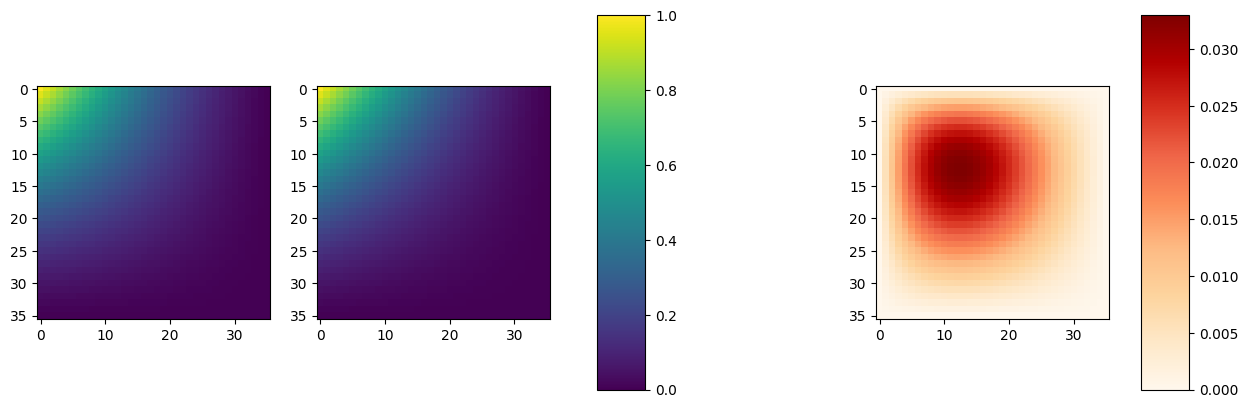

In [62]:
solver = Solver(a, b, c, lx, ly, f, alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, nx, ny)
solver = solver.solve(u0 = .5, epsilon = 0.0001, mode = 1)
solver.draw(solution)

Seidel Method: Iterations: 694


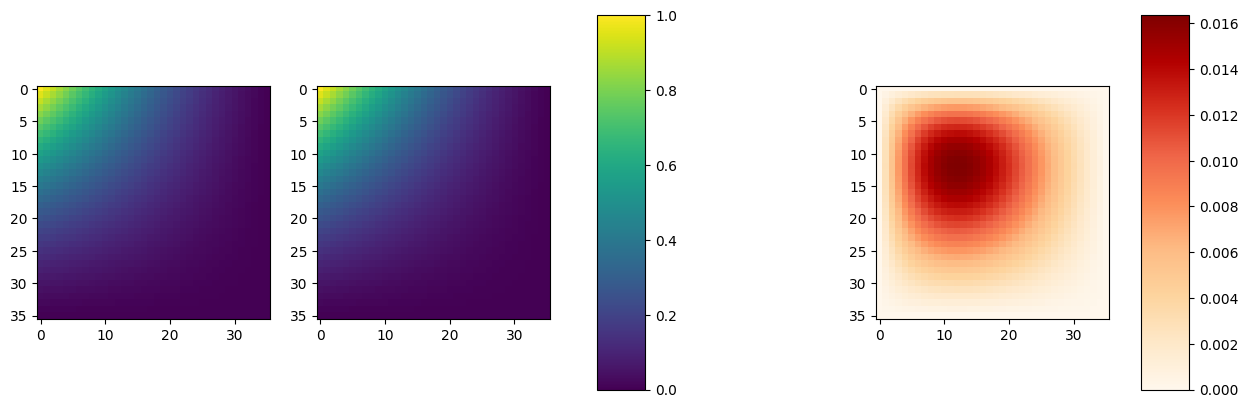

In [63]:
solver = Solver(a, b, c, lx, ly, f, alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, nx, ny)
solver = solver.solve(u0 = 0.5, epsilon = 0.0001, mode = 2)
solver.draw(solution)

Relaxation Method w=1.75: Iterations: 155


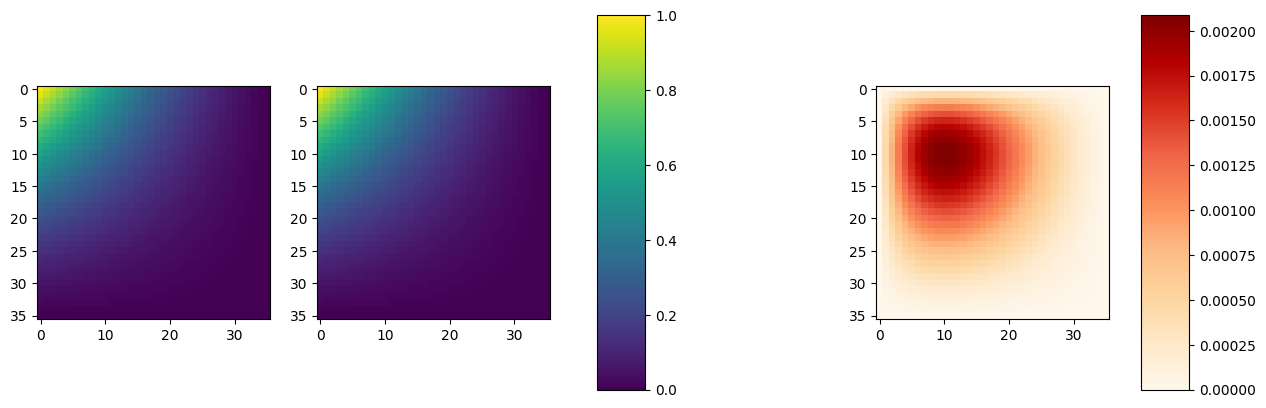

In [64]:
solver = Solver(a, b, c, lx, ly, f, alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, nx, ny)
solver = solver.solve(u0 = 0.5, epsilon = 0.0001, mode = 3, w = 1.75)
solver.draw(solution)